<a href="https://colab.research.google.com/github/Jojo18-20/AI_course_submission/blob/main/modul5_assigment3_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Johanna Schaefer -Module 5- Assigment 3

In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as dis_lib


In [2]:
data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")

In [3]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

/tmp/ipython-input-2050002240.py:22: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])
/tmp/ipython-input-2050002240.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])


[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


Data exploration

In [4]:
print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


(288,)


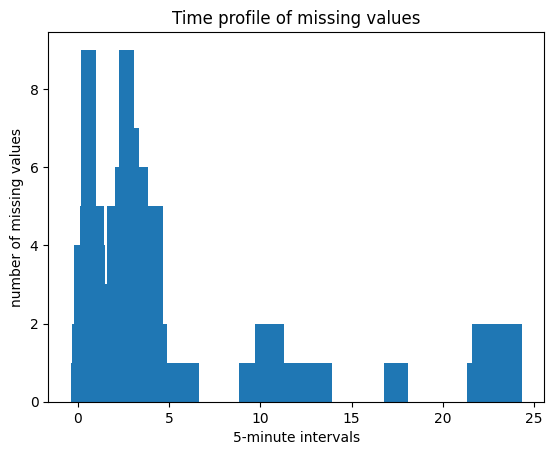

In [5]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


In [10]:
print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

[ 25  49  52  86  87  88 137 138 139 185 187 207 208 209 217 247 248 249
 250 251 266 275 276 277 299 306 311 341]


In [22]:
X_train, X_test = train_test_split(vectorized_day_dataset_no_nans, test_size=0.2, random_state=42, shuffle=True)


Clustering

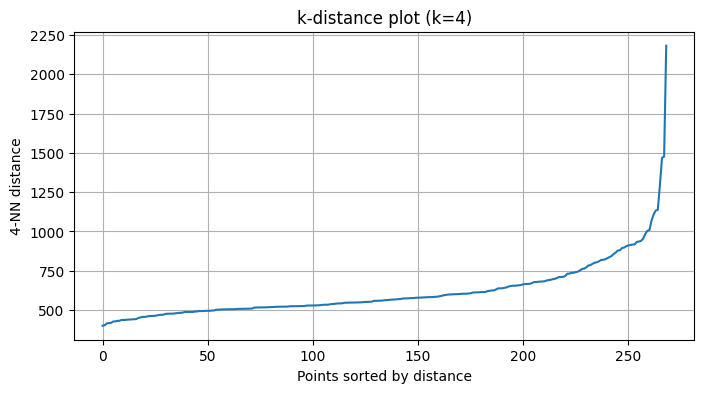

eps candidates (use one near knee): [634.95815532 697.25069788 759.74527291 838.19577559 935.05643724]


In [36]:

min_samples = 5
k = min_samples - 1  # k-th neighbor
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_train)
distances, indices = nbrs.kneighbors(X_train)


k_dist = np.sort(distances[:, k])

# Plot
plt.figure(figsize=(8,4))
plt.plot(k_dist)
plt.ylabel(f"{k}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title(f"k-distance plot (k={k})")
plt.grid()
plt.show()

# eps-Kandidaten: z.B. Percentiles um das "Knie"
eps_candidates = np.percentile(k_dist, [70, 80, 85, 90, 95])
print("eps candidates (use one near knee):", eps_candidates)


In [ ]:
def evaluate_clustering(method, model, X_train, X_test, params):
    labels = None
    if method == "GMM":
        model.fit(X_train)
        labels = model.predict(X_train)
    else:
        labels = model.fit_predict(X_train)

    if len(np.unique(labels)) > 1 and np.any(labels != -1):
        sil = silhouette_score(X_train, labels)
        db  = davies_bouldin_score(X_train, labels)
        ch  = calinski_harabasz_score(X_train, labels)
    else:
        sil, db, ch = np.nan, np.nan, np.nan

    # Cluster-Zentren bestimmen
    if method == "GMM":
        unique = np.unique(labels)
        centroids = np.vstack([X_train[labels == u].mean(axis=0) for u in unique])
        test_labels = model.predict(X_test)
    elif method == "DBSCAN":
        unique = np.unique(labels)
        centroids = {u: X_train[labels == u].mean(axis=0) for u in unique if u != -1}
        global_mean = X_train.mean(axis=0)
        preds = []
        for x in X_test:
            if len(centroids) == 0:
                preds.append(global_mean)
            else:
                dists = {l: np.linalg.norm(x - c) for l, c in centroids.items()}
                nearest = min(dists, key=dists.get)
                preds.append(centroids[nearest])
        preds = np.vstack(preds)
    else:
        unique = np.unique(labels)
        centroids = np.vstack([X_train[labels == u].mean(axis=0) for u in unique])
        preds = []
        for x in X_test:
            dists = np.linalg.norm(centroids - x, axis=1)
            nearest = np.argmin(dists)
            preds.append(centroids[nearest])
        preds = np.vstack(preds)

    if method != "DBSCAN":
        preds = np.vstack([centroids[list(unique).index(l)] for l in test_labels]) if method == "GMM" else preds

    # external metrics
    rmse = math.sqrt(mean_squared_error(X_test, preds))
    mae  = mean_absolute_error(X_test, preds)


    results.append({
        "Method": method,
        "Params": params,
        "Silhouette": sil,
        "DaviesBouldin": db,
        "CalinskiHarabasz": ch,
        "RMSE_Test": rmse,
        "MAE_Test": mae
    })


In [48]:
nans_per_day_test = np.sum(np.isnan(X_test), 1)
#days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]
print(nans_per_day_test)
X_train.shape
X_test.shape
vectorized_day_dataset_no_nans.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(337, 288)

In [52]:
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    for i in range(len(centroids)):
        # nur den relevanten Zeitbereich vergleichen
        ed_t = dis_lib.paired_distances(
            centroids[i][:, from_interval:to_interval+1],
            new_day[:, from_interval:to_interval+1],
            metric='euclidean'
        )

        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

def evaluate_clustering(method, model, X_train, X_test, params):
    labels = None
    if method == "GMM":
        model.fit(X_train)
        labels = model.predict(X_train)
    else:
        labels = model.fit_predict(X_train)

    if len(np.unique(labels)) > 1 and np.any(labels != -1):
        sil = silhouette_score(X_train, labels)
        db  = davies_bouldin_score(X_train, labels)
        ch  = calinski_harabasz_score(X_train, labels)
    else:
        sil, db, ch = np.nan, np.nan, np.nan

    # Initialize a list to store centroid data
    centroids = []
    # Calculate centroids for each cluster
    for i in np.unique(labels):
      centroid = np.nanmean(X_train[np.where(labels == i)[0], :], 0).reshape(1, nintvals)
      centroids.append(centroid)

    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5

    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
    for i in range(0, X_test.shape[0]):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, X_test[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]

            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - X_test[i][j + 1])
            mape_t = abs(predicted_value - X_test[i][j + 1]) / float(X_test[i][j + 1])

            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1


    results.append({
        "Method": method,
        "Params": params,
        "Silhouette": sil,
        "DaviesBouldin": db,
        "CalinskiHarabasz": ch,
        "accuracy MAE": total_mae / prediction_counts,
        "accuracy MAPE": total_mape / prediction_counts
    })


In [53]:
results = []

labels = None
n_clusters = [2,4,6,8,10,12]  # Cluster

for k in n_clusters:
    # KMeans
    km = KMeans(n_clusters=k, random_state=42)
    evaluate_clustering("KMeans", km, X_train, X_test, {"n_clusters": k})

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    evaluate_clustering("GMM", gmm, X_train, X_test, {"n_components": k})

    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k)
    evaluate_clustering("Agglomerative", agg, X_train, X_test, {"n_clusters": k})

    print(k,"done")

# DBSCAN separate, eps und min_samples vary
for eps in [400, 500, 600, 700, 800]:
    for ms in [2,4,6]:
        db = DBSCAN(eps=eps, min_samples=ms)
        evaluate_clustering("DBSCAN", db, X_train, X_test, {"eps": eps, "min_samples": ms})
    print (eps, "done")



2 done
4 done
6 done
8 done
10 done
12 done
400 done
500 done
600 done
700 done
800 done


In [54]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="accuracy MAE"))

           Method                          Params  Silhouette  DaviesBouldin  \
17  Agglomerative              {'n_clusters': 12}    0.163210       1.762242   
14  Agglomerative              {'n_clusters': 10}    0.166805       1.754096   
16            GMM            {'n_components': 12}    0.169686       1.627302   
15         KMeans              {'n_clusters': 12}    0.169686       1.627302   
11  Agglomerative               {'n_clusters': 8}    0.191241       1.368608   
13            GMM            {'n_components': 10}    0.194555       1.677786   
12         KMeans              {'n_clusters': 10}    0.194555       1.677786   
8   Agglomerative               {'n_clusters': 6}    0.225368       1.440012   
9          KMeans               {'n_clusters': 8}    0.219234       1.750012   
10            GMM             {'n_components': 8}    0.219234       1.750012   
22         DBSCAN  {'eps': 500, 'min_samples': 4}   -0.102801       2.259884   
21         DBSCAN  {'eps': 500, 'min_sam

In [23]:
n_clusters = 10
clusters = None

clustering_methods = [
    {"name": "KMeans", "model": KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")},
    {"name": "Agglomerative", "model": AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')},
    {"name": "DBSCAN", "model": DBSCAN(eps=500, min_samples=2)},
    {"name": "GMM", "model": GaussianMixture(n_components=n_clusters)}
]

for method in clustering_methods:
    print(f"\nRunning clustering with: {method['name']}")
    model = method["model"]

    if method["name"] == "GMM":
        cluster_labels = model.fit(X_train).predict(X_train)
    else:
        clusters = model.fit(X_train)
        cluster_labels = clusters.labels_
    SC_score = silhouette_score(X_train, cluster_labels)
    DB_score = davies_bouldin_score(X_train, cluster_labels)
    CH_score = calinski_harabasz_score(X_train, cluster_labels)
    total_score=SC_score-DB_score+np.log(CH_score+1)

    print(cluster_labels)
    print('Silhouette Score:', SC_score)
    print('Davies-Bouldin Score:', DB_score)
    print('Calinski-Harabasz Score:', CH_score)
    print("total SCore",total_score)



Running clustering with: KMeans
[1 7 9 8 9 2 7 9 7 2 2 6 6 1 9 7 7 9 7 7 4 8 7 7 7 2 1 6 7 7 1 7 8 7 3 2 9
 9 1 2 1 6 1 8 7 2 7 7 8 6 2 9 8 7 6 6 8 8 2 2 9 4 8 3 9 8 8 7 1 3 2 7 8 9
 9 7 7 3 6 7 6 7 7 9 7 1 7 9 2 7 6 9 8 9 9 7 1 6 6 7 6 7 9 0 3 9 5 7 7 7 6
 6 8 3 8 5 1 6 9 9 6 7 2 1 8 9 1 2 8 7 2 3 3 7 7 7 7 9 8 8 9 6 9 7 2 2 6 7
 7 4 3 7 6 7 3 6 1 6 1 7 6 1 9 0 8 7 8 3 7 3 7 8 6 5 2 9 6 6 2 9 7 9 9 9 2
 7 7 1 4 7 3 7 9 3 2 2 7 2 6 7 7 6 7 7 7 6 7 9 6 7 6 9 3 9 6 7 8 8 3 3 8 5
 2 7 8 8 9 9 2 3 7 4 3 7 1 7 1 8 2 6 9 9 7 2 1 7 7 8 6 2 7 6 6 9 6 7 7 7 8
 3 7 9 3 8 6 8 8 7 8]
Silhouette Score: 0.1831182887186136
Davies-Bouldin Score: 1.6680273638821574
Calinski-Harabasz Score: 57.43904653634981
total SCore 2.583075196328327

Running clustering with: Agglomerative
[6 0 1 7 1 7 0 1 0 7 7 4 3 6 1 9 0 1 0 0 5 8 0 9 0 7 6 4 0 0 6 0 8 0 2 1 1
 1 6 7 6 4 6 8 9 7 0 0 8 4 7 1 8 0 3 4 8 7 1 7 1 9 8 2 1 8 8 9 6 2 7 0 8 1
 1 9 9 2 4 0 4 0 0 1 0 6 9 1 7 0 4 1 8 1 1 0 6 4 4 0 4 0 1 0 2 1 3 0 9 0 4
 3 8

In [18]:
n_clusters = 10
clusters = None

clustering_methods = [
    {"name": "KMeans", "model": KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")},
    {"name": "Agglomerative", "model": AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')},
    {"name": "DBSCAN", "model": DBSCAN(eps=500, min_samples=2)},
    {"name": "GMM", "model": GaussianMixture(n_components=n_clusters)}
]

for method in clustering_methods:
    print(f"\nRunning clustering with: {method['name']}")
    model = method["model"]

    if method["name"] == "GMM":
        cluster_labels = model.fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans)
    else:
        clusters = model.fit(vectorized_day_dataset_no_nans)
        cluster_labels = clusters.labels_
    SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    total_score=SC_score-DB_score+np.log(CH_score+1)

    print(cluster_labels)
    print('Silhouette Score:', SC_score)
    print('Davies-Bouldin Score:', DB_score)
    print('Calinski-Harabasz Score:', CH_score)
    print("total SCore",total_score)



Running clustering with: KMeans
[4 4 4 9 1 4 9 9 4 4 5 9 9 9 9 4 4 9 9 3 3 3 4 4 9 9 5 9 4 4 9 5 9 9 9 4 4
 9 9 9 5 9 4 4 9 9 3 3 4 4 3 3 3 9 4 4 3 3 9 3 9 4 4 3 9 9 9 3 4 4 3 3 3 3
 3 4 4 3 3 9 3 3 1 3 3 4 4 4 4 9 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 5 1 2 2 8 5 0 5 1 2 2 5 1 2 2 2 2 2 5 1 2 2 8 2 8 5 1
 2 2 8 8 8 5 1 2 8 2 2 0 5 1 2 2 8 2 5 4 1 8 0 2 8 0 5 7 0 8 0 5 5 0 0 0 0
 0 5 5 0 0 0 0 0 5 5 0 0 5 1 0 0 0 7 1 1 0 0 0 2 0 5 1 2 2 2 2 8 1 1 2 2 2
 2 8 1 1 2 2 2 2 8 5 2 1 1 2 2 8 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 8 5 1 2 2 2 8 0 1 1 8 2 2 2 1 1 6 6 6 6 4 1 6 6 6 6 1 1 6 6 6 6 6
 1 1 6 6 6 6 6 1 4 6 6 6 6 6 1 4 6 6 6 9 1 1 6 6 6 6 6 1 1 6 6 6 5 4 4 4 5
 1 1 1 4]
Silhouette Score: 0.1888295110481911
Davies-Bouldin Score: 1.7434244441047695
Calinski-Harabasz Score: 81.05449965897482
total SCore 2.8527887234264764

Running clustering with: Agglomerative
[8 1 1 6 0 1 0 0 1 1 4 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 4 0 1 1 0 4 0 0 0 1 1
 0 0 0 0 0 1 1 

Internal evaluation

In [13]:
# Calculate the Silhouette Score
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

Silhouette Score: 0.21506167345844876
Davies-Bouldin Score: 1.4150683146774594
Calinski-Harabasz Score: 78.95519615286356
